Training based on CVE descriptions

In [3]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_descr_with_embeddings.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_description_ada_embedding'] for item in balanced if item['cwe'] != 'None'])
test = np.array([item['cwe'] for item in balanced if item['cwe'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_description_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train.joblib')

Epoch 1/40
260/260 [==============================] - 1s 3ms/step lo
Epoch 1 - F1 Score: 0.5860
Saved best model
[0.5859872160803034]
2336/2336 [==============================] - 19s 8ms/step - loss: 1.9310 - accuracy: 0.4892 - val_loss: 1.3600 - val_accuracy: 0.6139
Epoch 2/40
260/260 [==============================] - 1s 3ms/step 
Epoch 2 - F1 Score: 0.6414
Saved best model
[0.5859872160803034, 0.6413542955201157]
2336/2336 [==============================] - 17s 7ms/step - loss: 1.2757 - accuracy: 0.6345 - val_loss: 1.2016 - val_accuracy: 0.6552
Epoch 3/40
260/260 [==============================] - 1s 3ms/step 
Epoch 3 - F1 Score: 0.6540
Saved best model
[0.5859872160803034, 0.6413542955201157, 0.6539693646782548]
2336/2336 [==============================] - 18s 8ms/step - loss: 1.1493 - accuracy: 0.6694 - val_loss: 1.1282 - val_accuracy: 0.6716
Epoch 4/40
260/260 [==============================] - 1s 3ms/step
Epoch 4 - F1 Score: 0.6698
Saved best model
[0.5859872160803034, 0.6413542

['label_encoder_train.joblib']

Inference on descriptions

In [1]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
import joblib
from sklearn.preprocessing import LabelEncoder
# Save the best model
with open('test_descr_with_embeddings.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

X_test = np.array([item['cve_description_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

best_model=joblib.load('best_model.joblib')
label_encoder_train=joblib.load('label_encoder_train.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

444/444 [==============================] - 1s 1ms/step
Classification Report:
               precision    recall  f1-score   support

         119     0.8360    0.4430    0.5791      1070
         120     0.3523    0.8782    0.5029       197
         125     0.6231    0.8719    0.7268       531
         134     0.5926    0.8421    0.6957        19
         189     0.6519    0.7333    0.6902       120
         190     0.6343    0.8586    0.7296       198
          20     0.4128    0.2222    0.2889       810
         200     0.5833    0.5458    0.5639       590
         203     0.5000    0.7037    0.5846        27
          22     0.7918    0.8958    0.8406       518
         254     0.0645    0.0588    0.0615        34
         255     0.3919    0.4328    0.4113        67
         264     0.6274    0.5199    0.5686       502
         269     0.3684    0.4667    0.4118       105
         276     0.3750    0.2812    0.3214        64
         284     0.2381    0.2033    0.2193       123
  

In [2]:
import joblib# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc1/X_test.joblib')
y_test = joblib.load('reproduc1/y_test.joblib')
y_pred_original = joblib.load('reproduc1/y_pred_original.joblib')
unbalanced = joblib.load('reproduc1/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0
total_words=0
# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    total_words+=description_words
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

print("Average words per sentence:", total_words/i)

Total Sentences Below Short Threshold: 1546
Misclassified Short Sentences: 677
Percentage of Misclassified Short Sentences: 43.79042690815007
Total Sentences Above Long Threshold: 1559
Misclassified Long Sentences: 816
Percentage of Misclassified Long Sentences: 52.34124438742784
Average words per sentence: 40.64354622913879


In [3]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)


Total Sentences: 14202
Misclassified Sentences: 5619
Percentage of Misclassified Sentences: 39.56485002112379


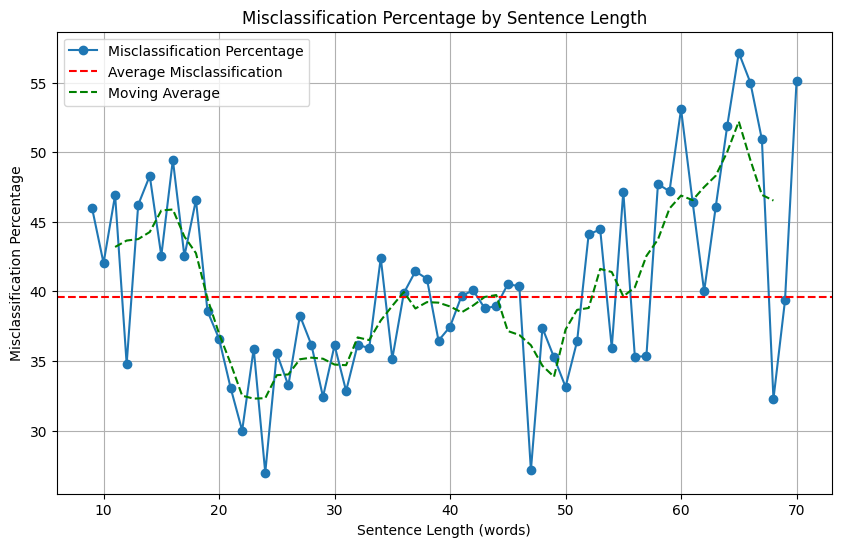

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 70 or description_words < 9:
        # print(unbalanced[i]['cve_description'])
        # print(actual_label, predicted_label)
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()



In [22]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_descr_with_embeddings.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_description_ada_embedding'] for item in balanced if item['cwe_class'] != 'None'])
test = np.array([item['cwe_class'] for item in balanced if item['cwe_class'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_description_ada_embedding'] for item in unbalanced if item['cwe_class'] != 'None'])
y_test = np.array([item['cwe_class'] for item in unbalanced if item['cwe_class'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_class.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_class.joblib')

Epoch 1/40
226/226 [==============================] - 0s 2ms/step loss: 1.2239 - a
Epoch 1 - F1 Score: 0.7389
Saved best model
[0.738852962955081]
2034/2034 [==============================] - 10s 4ms/step - loss: 1.2232 - accuracy: 0.6556 - val_loss: 0.8399 - val_accuracy: 0.7554
Epoch 2/40
226/226 [==============================] - 0s 2ms/step loss: 0.7752 - 
Epoch 2 - F1 Score: 0.7766
Saved best model
[0.738852962955081, 0.7766082804853741]
2034/2034 [==============================] - 9s 4ms/step - loss: 0.7752 - accuracy: 0.7745 - val_loss: 0.7454 - val_accuracy: 0.7828
Epoch 3/40
226/226 [==============================] - 0s 2ms/step loss: 0.6928 - ac
Epoch 3 - F1 Score: 0.7830
Saved best model
[0.738852962955081, 0.7766082804853741, 0.7829546442820242]
2034/2034 [==============================] - 8s 4ms/step - loss: 0.6928 - accuracy: 0.7979 - val_loss: 0.7228 - val_accuracy: 0.7893
Epoch 4/40
226/226 [==============================] - 1s 2ms/step loss: 0.6
Epoch 4 - F1 Score: 0.7

['label_encoder_train_class.joblib']

In [25]:
# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc2/X_test.joblib')
y_test = joblib.load('reproduc2/y_test.joblib')
y_pred_original = joblib.load('reproduc2/y_pred_original.joblib')
unbalanced = joblib.load('reproduc2/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0
total_words=0
# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    total_words+=description_words
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

print("Average words per sentence:", total_words/i)

Total Sentences Below Short Threshold: 1430
Misclassified Short Sentences: 378
Percentage of Misclassified Short Sentences: 26.433566433566437
Total Sentences Above Long Threshold: 1412
Misclassified Long Sentences: 305
Percentage of Misclassified Long Sentences: 21.600566572237963
Average words per sentence: 40.62028962939894


In [26]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)

Total Sentences: 12845
Misclassified Sentences: 3122
Percentage of Misclassified Sentences: 24.30517711171662


In [24]:
joblib.dump(X_test, 'reproduc2/X_test.joblib')
joblib.dump(y_test, 'reproduc2/y_test.joblib')
joblib.dump(y_pred_original, 'reproduc2/y_pred_original.joblib')
joblib.dump(unbalanced, 'reproduc2/unbalanced.joblib')

['reproduc2/unbalanced.joblib']

In [33]:
short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 60  # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)


Total Sentences Below Short Threshold: 1429
Misclassified Short Sentences: 316
Percentage of Misclassified Short Sentences: 22.113365990202936
Total Sentences Above Long Threshold: 1693
Misclassified Long Sentences: 356
Percentage of Misclassified Long Sentences: 21.027761370348493


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 120:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
# plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'X_test' is not defined

In [28]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4_high_abstr.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_descr_with_embeddings_high_abstr.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_description_ada_embedding'] for item in balanced if item['cwe_high_abstraction'] != 'None'])
test = np.array([item['cwe_high_abstraction'] for item in balanced if item['cwe_high_abstraction'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_description_ada_embedding'] for item in unbalanced if item['cwe_high_abstraction'] != 'None'])
y_test = np.array([item['cwe_high_abstraction'] for item in unbalanced if item['cwe_high_abstraction'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_abs.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_abs.joblib')

Epoch 1/40
225/225 [==============================] - 0s 1ms/step loss: 0.8266 - accur
Epoch 1 - F1 Score: 0.7914
Saved best model
[0.7914138468144832]
2023/2023 [==============================] - 8s 4ms/step - loss: 0.8253 - accuracy: 0.7252 - val_loss: 0.6111 - val_accuracy: 0.7954
Epoch 2/40
225/225 [==============================] - 0s 1ms/step loss: 0.5684 - accu
Epoch 2 - F1 Score: 0.8209
Saved best model
[0.7914138468144832, 0.8208857447579142]
2023/2023 [==============================] - 6s 3ms/step - loss: 0.5686 - accuracy: 0.8152 - val_loss: 0.5452 - val_accuracy: 0.8211
Epoch 3/40
225/225 [==============================] - 0s 1ms/step loss: 0.5231 - accura
Epoch 3 - F1 Score: 0.8210
Saved best model
[0.7914138468144832, 0.8208857447579142, 0.8209627497896016]
2023/2023 [==============================] - 7s 3ms/step - loss: 0.5236 - accuracy: 0.8307 - val_loss: 0.5558 - val_accuracy: 0.8194
Epoch 4/40
225/225 [==============================] - 0s 1ms/step loss: 0.4891 - accu

['label_encoder_train_abs.joblib']

In [29]:
joblib.dump(X_test, 'reproduc3/X_test.joblib')
joblib.dump(y_test, 'reproduc3/y_test.joblib')
joblib.dump(y_pred_original, 'reproduc3/y_pred_original.joblib')
joblib.dump(unbalanced, 'reproduc3/unbalanced.joblib')

['reproduc3/unbalanced.joblib']

In [2]:
import joblib# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc3/X_test.joblib')
y_test = joblib.load('reproduc3/y_test.joblib')
y_pred_original = joblib.load('reproduc3/y_pred_original.joblib')
unbalanced = joblib.load('reproduc3/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0
total_words=0
# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    total_words+=description_words
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

print("Average words per sentence:", total_words/i)


Total Sentences Below Short Threshold: 1429
Misclassified Short Sentences: 310
Percentage of Misclassified Short Sentences: 21.693491952414277
Total Sentences Above Long Threshold: 1405
Misclassified Long Sentences: 310
Percentage of Misclassified Long Sentences: 22.064056939501782
Average words per sentence: 40.6145443196005


In [3]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)

Total Sentences: 12817
Misclassified Sentences: 2858
Percentage of Misclassified Sentences: 22.29850979168292


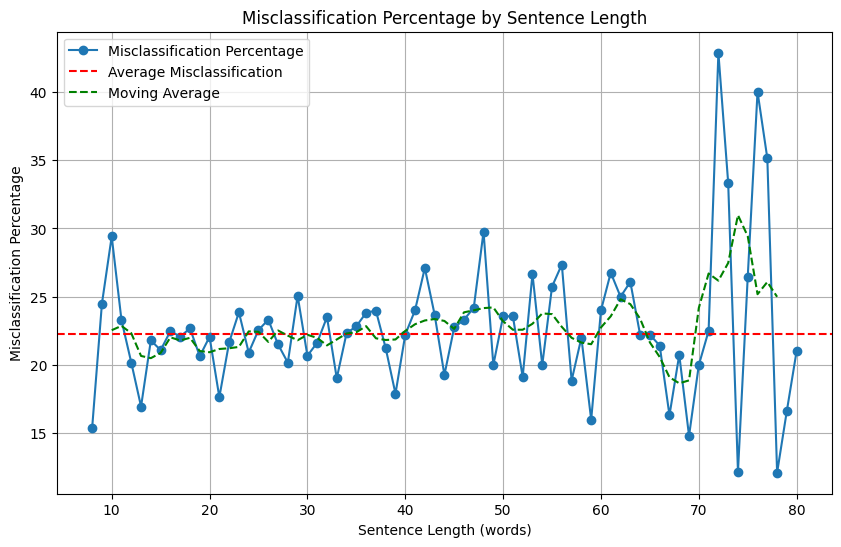

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 80 or description_words < 8:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()